In [72]:
# we need a python2 version of pyupset
# !pip uninstall -y pyupset
# !pip install https://github.com/agitter/py-upset/archive/master.zip
# !pip install seaborn

In [188]:
# 
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, A, Q , aggs, query

from collections import Counter, defaultdict
import pandas as pd
import pyupset as pyu
import re
import itertools
import json
from IPython.display import set_matplotlib_formats
from collections import namedtuple
from __future__ import division
import numpy as np
import json
#  The resulting plots will then also be stored in the notebook document.
%matplotlib inline

In [144]:
# connect to elastic
HOST = ['elastic:9200']
client = Elasticsearch(HOST)
# validate connection
assert(client.info()['version'])


# Total Associations
### For all G2P sources, show the counts and overlaps


In [145]:
# Use DSL to aggregate counts on the server
s = Search(using=client, index="associations")
# limit query to 1K sources, 1M genes each
s.aggs.bucket('source', 'terms', field='source.keyword', size=1000) \
      .bucket('genes', 'terms',field='genes.keyword', size=1000000)
aggregation = s.execute()
# Create dataframe to hold results
gene_counts = pd.DataFrame([ {'source':source.key,
                     'evidence_count': source.doc_count,
                     'genes_count': len(source.genes.buckets),
                     'genes':[ {'gene': gene.key, 'count': gene.doc_count}
                        for gene in source.genes.buckets
                     ],
                     'gene_names': [gene.key for gene in source.genes.buckets]
                    } 
                    for source in aggregation.aggregations.source.buckets])
gene_counts = gene_counts.set_index('source')
gene_counts[['evidence_count', 'genes_count', 'genes','gene_names']]


,evidence_count,genes_count,genes,gene_names
source,,,,
molecularmatch_trials,57552,1042,"[{u'count': 6924, u'gene': u'KMT2A'}, {u'count...","[KMT2A, EGFR, HLA-A, VEGF, Wild-Type ERBB2, ER..."
brca,5733,2,"[{u'count': 3406, u'gene': u'BRCA2'}, {u'count...","[BRCA2, BRCA1]"
oncokb,4149,276,"[{u'count': 295, u'gene': u'BRCA1'}, {u'count'...","[BRCA1, KIT, EGFR, TP53, BRAF, PTEN, BRCA2, PD..."
jax,3649,158,"[{u'count': 541, u'gene': u'EGFR'}, {u'count':...","[EGFR, ALK, ERBB2, BRAF, KIT, FGFR2, FLT3, FGF..."
civic,3176,292,"[{u'count': 329, u'gene': u'KRAS'}, {u'count':...","[KRAS, VHL, ABL1, EGFR, BRAF, ALK, PIK3CA, ERB..."
molecularmatch,2079,111,"[{u'count': 446, u'gene': u'KRAS'}, {u'count':...","[KRAS, EGFR, PIK3CA, ESR1, MET, ALK, ERBB2, BR..."
cgi,1431,183,"[{u'count': 153, u'gene': u'EGFR'}, {u'count':...","[EGFR, ABL1, ERBB2, BRAF, NF1, ALK, KRAS, KIT,..."
jax_trials,1131,58,"[{u'count': 355, u'gene': u'ERBB2'}, {u'count'...","[ERBB2, EGFR, BRAF, ALK, KRAS, BRCA1, BRCA2, N..."
pmkb,609,42,"[{u'count': 72, u'gene': u'SF3B1'}, {u'count':...","[SF3B1, KRAS, BRAF, CTNNB1, PIK3CA, EGFR, FLT3..."


# Genes Overlap
### For each source, list the count of genes that overlap

In [146]:
# lightweight class
Overlap = namedtuple('Overlap', ['other', 'source', 'size', 'percentage', 'other_size', 'source_size',
                                 'other_gene_names' ])

# intersection
def genes_intersection(df1, df2):
    return set(df1.gene_names) & set(df2.gene_names)

# comparison of source to all other sources
def source_intersection(source):
    others = set(gene_counts.index.tolist()) - set([source])
    for other in others:
        overlap_size = len(genes_intersection(gene_counts.loc[source], gene_counts.loc[other]))
        other_size = len(gene_counts.loc[other].gene_names)
        yield Overlap(other=other,
                      source=source,
                      size=overlap_size,
                      other_size=other_size,
                      source_size=len(gene_counts.loc[source].gene_names),
                      percentage=(overlap_size / other_size) * 100,
                      other_gene_names=set(gene_counts.loc[other].gene_names)
                     ) 

overlaps = [] # for plotting
print('overall overlap')
for source in gene_counts.index.tolist():
    total = set()
    for overlap in source_intersection(source):
        overlaps.append(overlap)  # for plotting
        total |= overlap.other_gene_names  # for overall
#         print('    {}/{} ({:.2f}%) overlap with {}'.format(overlap.size,
#                                                            overlap.other_size,
#                                                            overlap.percentage,
#                                                            overlap.other))
    overall = set(gene_counts.loc[source].gene_names) & total
    print('  {}: {}/{} ({:.2f}%)'.format(source, len(overall), len(total), len(overall) / len(total)* 100))
    

overall overlap
  molecularmatch_trials: 330/604 (54.64%)
  brca: 2/1316 (0.15%)
  oncokb: 227/1267 (17.92%)
  jax: 49/1207 (4.06%)
  civic: 220/1244 (17.68%)
  molecularmatch: 108/1313 (8.23%)
  cgi: 169/1302 (12.98%)
  jax_trials: 54/1312 (4.12%)
  pmkb: 41/1315 (3.12%)
  sage: 2/1316 (0.15%)


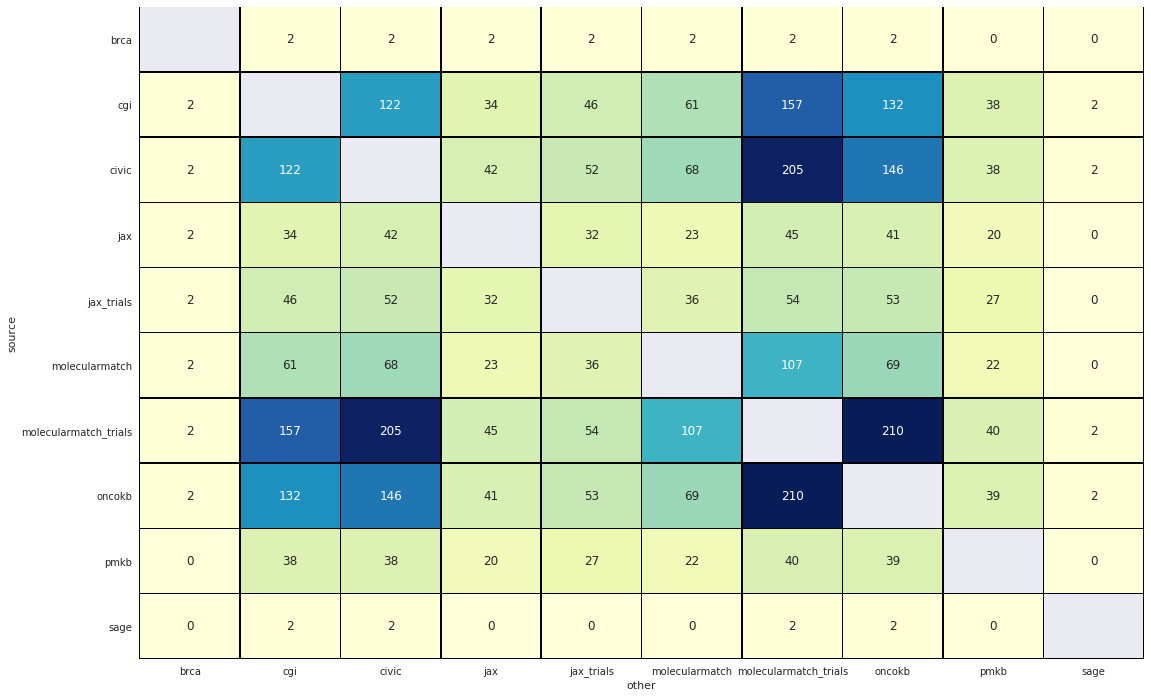

In [147]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.set()
# Load the overlaps into pd and pivot
overlaps_hm = pd.DataFrame(overlaps).pivot("source", "other", "size")
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(overlaps_hm, annot=True, fmt="1.0f", linewidths=.5, ax=ax, cbar=False, cmap="YlGnBu",linecolor='black') 


# Harmonization results

In [229]:
# Use DSL to aggregate counts on the server
# query prototyped in kibana
q='{"query":{"query_string":{"analyze_wildcard":true,"query":"*"}},"size":0,"_source":{"excludes":[]},"aggs":{"source":{"terms":{"field":"source.keyword","size":1000,"order":{"_count":"desc"}},"aggs":{"harmonization":{"filters":{"filters":{"missing_disease_ontology":{"query_string":{"analyze_wildcard":true,"query":"\\"no-doid\\""}},"all":{"query_string":{"analyze_wildcard":true,"query":"*"}},"missing_pubchem":{"query_string":{"analyze_wildcard":true,"query":"\\"no-pubchem\\""}},"missing_genomic_location":{"query_string":{"analyze_wildcard":true,"query":"_exists_:features.description AND NOT _exists_:features.start"}},"missing_biomarker":{"query_string":{"analyze_wildcard":true,"query":"_exists_:features.description AND NOT _exists_:features.biomarker_type.keyword"}},"gene_only":{"query_string":{"query":"NOT _exists_:features.name","analyze_wildcard":true}}}}}}}}}'
res = client.search(index="associations", doc_type="association", body=json.loads(q))


In [242]:
# Make aggregations panda friendly
def convert(dictionary):
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

harmonization_results = []
for bucket in res['aggregations']['source']['buckets']:    
    o = {}
    b = bucket['harmonization']['buckets']
    o['source'] = bucket['key']
    for key in [k for k in b]:
      o[key] = b[key]['doc_count']
    harmonization_results.append(convert(o))
harmonization_results = pd.DataFrame(harmonization_results)
harmonization_results = harmonization_results.set_index('source')
harmonization_results

,all,missing_disease_ontology,gene_only,missing_pubchem,missing_biomarker,missing_genomic_location
source,,,,,,
molecularmatch_trials,57552,5767,34630,2491,5987,21250
brca,5733,0,0,0,0,0
oncokb,4149,16,0,24,0,239
jax,3649,1,0,183,0,0
civic,3176,38,0,27,0,0
molecularmatch,2079,3,149,31,0,0
cgi,1431,112,0,140,0,842
jax_trials,1131,0,0,33,0,0
pmkb,609,51,0,0,0,0


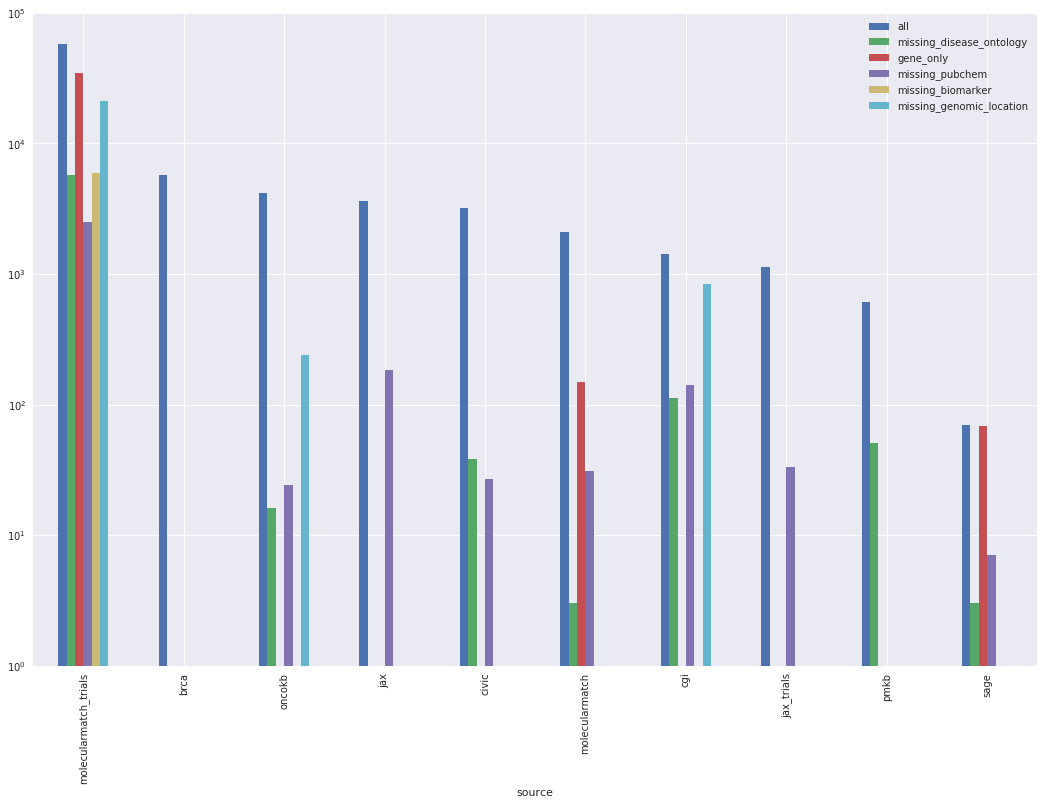

In [245]:
harmonization_results.plot(kind='bar',log=True,figsize=(18, 12))

In [22]:
%%capture
failed = list(select_failures(res['hits']['hits']))

In [23]:
print("{:.2f}% of associations not fully normalized across gene, drug, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

42.32% of associations not fully normalized across gene, drug, phenotype


In [24]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({'cgi': 891,
         'civic': 70,
         'jax': 1838,
         'molecularmatch': 2769,
         'oncokb': 51,
         'pmkb': 606})

In [25]:
def percent(num, den):
    return "{:.2f}%".format(num / den * 100)

d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{'cgi': '62.35%',
 'civic': '2.58%',
 'jax': '28.22%',
 'molecularmatch': '90.02%',
 'oncokb': '13.67%',
 'pmkb': '100.00%'}

In [26]:
failures = failure_types_by_source(res['hits']['hits'])
print('Drug failures:')
{source: percent(failures[0][source]['drug'], failures[1][source]) for source in failures[0]}

Drug failures:


{'cgi': '9.10%',
 'civic': '0.81%',
 'jax': '4.96%',
 'molecularmatch': '2.41%',
 'oncokb': '5.09%',
 'pmkb': '100.00%'}

In [27]:
{source: percent(failures[0][source]['phenotype'], failures[1][source]) for source in failures[0]}

{'cgi': '60.11%',
 'civic': '1.81%',
 'jax': '24.20%',
 'molecularmatch': '89.60%',
 'oncokb': '8.58%',
 'pmkb': '23.43%'}

PMKB interpretations (https://pmkb.weill.cornell.edu/therapies) do not list drugs.

In [28]:
pmkb = [x for x in failed if x['_source']['source'] == 'pmkb']
pmkb[0]['_source']['association']

{'description': 'Somatic activating mutation in MPL (W515L, W515K) has been reported in approximately 1%-10% of cases of JAK2 Val617Phe-negative myelofibrosis, essential thrombocythemia, a subset of cases of acute megakaryoblastic leukemia  and has been associated with sensitivity to JAK inhibitors.   The W515 mutations are typically not observed in polycythemia vera or other myeloid disorders (chronic myelomonocytic leukemia, myelodysplastic syndrome).  A Ser505Asn activating mutation has also been described in familial essential thrombocythemia.',
 'drug_labels': 'NA',
 'evidence': [{'description': '1',
   'evidenceType': {'sourceName': 'pmkb'},
   'info': {'publications': ['http://www.ncbi.nlm.nih.gov/pubmed/16834459',
     'http://www.ncbi.nlm.nih.gov/pubmed/14764528',
     'http://www.ncbi.nlm.nih.gov/pubmed/16868251',
     'http://www.ncbi.nlm.nih.gov/pubmed/19194467']}}],
 'evidence_label': 'A',
 'evidence_level': 1,
 'phenotype': {'description': 'myelofibrosis',
  'family': 'he

In [29]:
any(['environmentalContexts' in x['_source']['association'] for x in pmkb])

False

# Overlap of associations (gene + phenotype)

In [30]:
def select_failures(hits):
    pheno_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
        except:
            gene = ''
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            yield(hit)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [31]:
%%capture
failed = list(select_failures(res['hits']['hits']))

In [32]:
print("{:.2f}% of associations not fully normalized across gene, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

36.80% of associations not fully normalized across gene, phenotype


In [33]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({'cgi': 859,
         'civic': 49,
         'jax': 1576,
         'molecularmatch': 2756,
         'oncokb': 32,
         'pmkb': 142})

In [34]:
d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{'cgi': '60.11%',
 'civic': '1.81%',
 'jax': '24.20%',
 'molecularmatch': '89.60%',
 'oncokb': '8.58%',
 'pmkb': '23.43%'}

Prostate Adenocarcinoma?

In [35]:
cgi = [x for x in failed if x['_source']['source'] == 'cgi']
cgi[0]['_source']['association']

{'description': 'ABL1 Ponatinib (BCR-ABL inhibitor 3rd gen&Pan-TK inhibitor) Responsive',
 'drug_labels': 'PONATINIB',
 'environmentalContexts': [{'description': 'PONATINIB',
   'id': 'compound:CID24826799',
   'taxonomy': {'class': 'Benzenoids',
    'direct-parent': 'Benzanilides',
    'kingdom': 'Chemical entities',
    'subclass': 'Benzene and substituted derivatives',
    'superclass': 'Organic compounds'},
   'term': 'PONATINIB',
   'toxicity': 'The most common non-hematologic adverse reactions (≥ 20%) were hypertension, rash, abdominal pain, fatigue, headache, dry skin, constipation, arthralgia, nausea, and pyrexia. Hematologic adverse reactions included thrombocytopenia, anemia, neutropenia, lymphopenia, and leukopenia.',
   'usan_stem': 'tyrosine kinase inhibitors'}],
 'evidence': [{'description': 'Responsive',
   'evidenceType': {'sourceName': 'cgi'},
   'info': {'publications': ['https://www.google.com/#q=FDA']}}],
 'evidence_label': 'A',
 'evidence_level': 1,
 'phenotype': {

In [36]:
cgi[0]['_source']['cgi']

'{"Targeting": "", "Biomarker": "ABL1 (T315I)", "Source": "FDA", "cDNA": "c.944C>T", "Primary Tumor type": "CML;ALL", "individual_mutation": "ABL1:p.T315I", "Drug full name": "Ponatinib (BCR-ABL inhibitor 3rd gen&Pan-TK inhibitor)", "Association": "Responsive", "Drug family": "BCR-ABL inhibitor 3rd gen&Pan-TK inhibitor", "Curator": "CRubio-Perez;DTamborero;RDientsmann", "Drug": "Ponatinib", "Alteration": "ABL1:T315I", "gDNA": "chr9:g.133748283C>T", "Drug status": "Approved", "Gene": "ABL1", "transcript": "ENST00000318560", "strand": "+", "info": "CSQN=Missense;reference_codon=ACT;candidate_codons=ATC,ATA,ATT;candidate_mnv_variants=chr9:g.133748283_133748284delCTinsTC,chr9:g.133748283_133748284delCTinsTA;aliases=ENSP00000323315;source=Ensembl", "Assay type": "", "Alteration type": "MUT", "region": "inside_[cds_in_exon_6]", "Evidence level": "FDA guidelines", "gene": "ABL1", "Metastatic Tumor Type": ""}'

In [37]:
%%capture
set([x['_source']['association']['phenotype']['description'] for x in cgi])

In [38]:
def select_successes(hits):
    pheno_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
            hit['merged'] = {'gene': gene}
        except:
            hit['merged'] = {'gene': ''}
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            continue
        hit['merged']['phenotype'] = phenotype
        yield hit
        
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [39]:
%%capture
successes = list(select_successes(res['hits']['hits']))

In [40]:
s = Counter([x['_source']['source'] for x in successes])
s

Counter({'cgi': 570,
         'civic': 2664,
         'jax': 4937,
         'molecularmatch': 320,
         'oncokb': 341,
         'pmkb': 464})

In [41]:
success_by_source = dict()
for source in s:
    success_by_source[source] = set([(x['merged']['gene'], x['merged']['phenotype']) for x in successes if x['_source']['source'] == source])

In [42]:
%%capture
success_by_source

In [43]:
overlap(success_by_source)

cgi has 14/105 (13.33%) overlap with jax
cgi has 26/105 (24.76%) overlap with civic
cgi has 9/105 (8.57%) overlap with oncokb
cgi has 6/105 (5.71%) overlap with pmkb
cgi has 0/105 (0.00%) overlap with molecularmatch
cgi has 28/105 (26.67%) overlap overall
jax has 14/832 (1.68%) overlap with cgi
jax has 175/832 (21.03%) overlap with civic
jax has 37/832 (4.45%) overlap with oncokb
jax has 34/832 (4.09%) overlap with pmkb
jax has 9/832 (1.08%) overlap with molecularmatch
jax has 201/832 (24.16%) overlap overall
civic has 26/756 (3.44%) overlap with cgi
civic has 175/756 (23.15%) overlap with jax
civic has 32/756 (4.23%) overlap with oncokb
civic has 34/756 (4.50%) overlap with pmkb
civic has 6/756 (0.79%) overlap with molecularmatch
civic has 206/756 (27.25%) overlap overall
oncokb has 9/68 (13.24%) overlap with cgi
oncokb has 37/68 (54.41%) overlap with jax
oncokb has 32/68 (47.06%) overlap with civic
oncokb has 9/68 (13.24%) overlap with pmkb
oncokb has 0/68 (0.00%) overlap with molecu

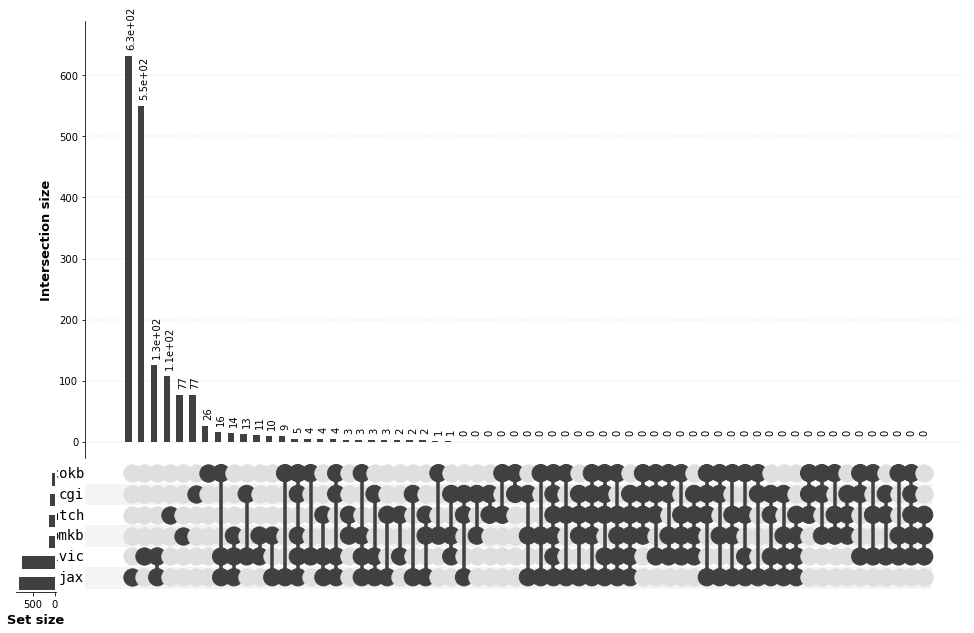

In [44]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names)
    
plot_overlap(success_by_source, column_names=['gene', 'phenotype'])


## Finding gene-PMID associations and comparing to gene-phenotype

This is some debugging code for issue 41: https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41

In [45]:
double_listed_refs = Counter()
single_listed_refs = Counter()

listed_evidence = Counter()
single_evidence = Counter()
for hit in res['hits']['hits']:
    if isinstance(hit['_source']['association']['evidence'], list):
        listed_evidence[hit['_source']['source']] += 1
        for evidence in hit['_source']['association']['evidence']:
            for pmid_url in evidence['info']['publications']:
                if isinstance(pmid_url, list):
                    double_listed_refs[hit['_source']['source']] += 1
                else:
                    single_listed_refs[hit['_source']['source']] += 1
    else:
        single_evidence[hit['_source']['source']] += 1
        evidence = hit['_source']['association']['evidence']
        for pmid_url in evidence['info']['publications']:
            if isinstance(pmid_url, list):
                double_listed_refs[hit['_source']['source']] += 1
            else:
                single_listed_refs[hit['_source']['source']] += 1

In [46]:
print(double_listed_refs)
print(single_listed_refs)
print(listed_evidence)
print(single_evidence)

Counter()
Counter({'jax': 6338, 'molecularmatch': 4821, 'pmkb': 3679, 'civic': 2713, 'cgi': 1859, 'oncokb': 172})
Counter({'jax': 6513, 'molecularmatch': 3076, 'civic': 2713, 'cgi': 1429, 'pmkb': 606, 'oncokb': 373})
Counter()


First, we'll look at just PMID overlap

In [47]:
pmid_re = re.compile(r'https?://www.ncbi.nlm.nih.gov/pubmed/(\d+)')
source_pmids = defaultdict(set)
single_url = Counter()
listed_url = Counter()
for hit in res['hits']['hits']:
    pmids = set()
    # next two lines fix double_listing, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
    if not isinstance(hit['_source']['association']['evidence'], list):
        hit['_source']['association']['evidence'] = [hit['_source']['association']['evidence']]
    for evidence in hit['_source']['association']['evidence']:
        urls = evidence['info']['publications']
    # next two lines fix single_evidence, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
        if urls and isinstance(urls[0], list):
            urls = itertools.chain.from_iterable(urls)
        for pmid_url in urls:
            match = pmid_re.match(pmid_url)
            if match:
                pmids.add(match.groups()[0])
    urls = hit['_source']['association'].get('publication_url')
    # the following lines document differences in the structure of the publication_url field
    if not isinstance(urls, list):
        single_url[hit['_source']['source']] += 1
        urls = [urls]
    else:
        listed_url[hit['_source']['source']] += 1
    for url in urls:
        if url is None:
            continue
        match = pmid_re.match(url)
        if match:
            pmids.add(match.groups()[0])
    source_pmids[hit['_source']['source']] |= pmids
    pmids = list(pmids)
    if 'merged' in hit:
        hit['merged']['pmids'] = pmids
    else:
        hit['merged'] = {'pmids': pmids}
    

In [48]:
{k: len(v) for k, v in source_pmids.items()}

{'cgi': 566,
 'civic': 1431,
 'jax': 1334,
 'molecularmatch': 945,
 'oncokb': 76,
 'pmkb': 335}

In [49]:
overlap(source_pmids)

cgi has 135/566 (23.85%) overlap with jax
cgi has 158/566 (27.92%) overlap with civic
cgi has 21/566 (3.71%) overlap with oncokb
cgi has 15/566 (2.65%) overlap with pmkb
cgi has 144/566 (25.44%) overlap with molecularmatch
cgi has 261/566 (46.11%) overlap overall
jax has 135/1334 (10.12%) overlap with cgi
jax has 217/1334 (16.27%) overlap with civic
jax has 15/1334 (1.12%) overlap with oncokb
jax has 32/1334 (2.40%) overlap with pmkb
jax has 205/1334 (15.37%) overlap with molecularmatch
jax has 360/1334 (26.99%) overlap overall
civic has 158/1431 (11.04%) overlap with cgi
civic has 217/1431 (15.16%) overlap with jax
civic has 27/1431 (1.89%) overlap with oncokb
civic has 36/1431 (2.52%) overlap with pmkb
civic has 621/1431 (43.40%) overlap with molecularmatch
civic has 730/1431 (51.01%) overlap overall
oncokb has 21/76 (27.63%) overlap with cgi
oncokb has 15/76 (19.74%) overlap with jax
oncokb has 27/76 (35.53%) overlap with civic
oncokb has 3/76 (3.95%) overlap with pmkb
oncokb has 27

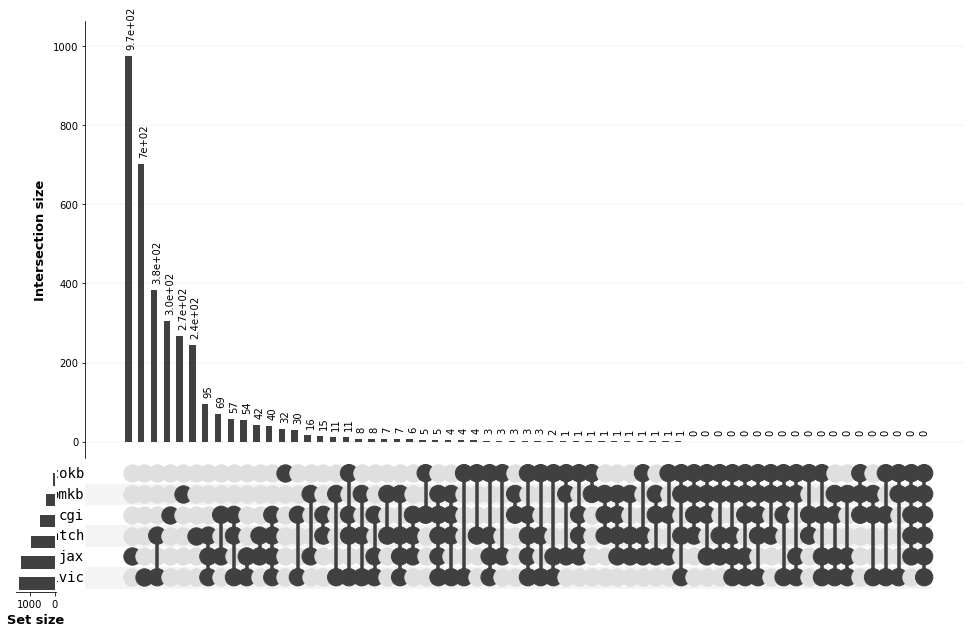

In [50]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names)
    
plot_overlap(source_pmids)

Parse PMIDs specifically for each source, see if differences exist.

Connect PMIDs to genes, phenotypes, gene + phenotype

In [62]:
pmid_dict = defaultdict(lambda: defaultdict(list))
for hit in res['hits']['hits']:
    pmids = hit.get('merged',{}).get('pmids',[])
    for pmid in pmids:
        pmid_dict[pmid][hit['_source']['source']].append(hit['merged'])

In [66]:
len(pmid_dict)

3433

In [81]:
multi_hit_pmids = {x: v for x, v in pmid_dict.items() if len(v) > 1}
len(multi_hit_pmids)

909

In [83]:
multi_hit_pmids['24569458']

defaultdict(list,
            {'cgi': [{'gene': 'ARAF', 'pmids': ['24569458']}],
             'civic': [{'gene': 'ARAF',
               'phenotype': 'DOID:3908',
               'pmids': ['24569458']},
              {'gene': 'ARAF',
               'phenotype': 'DOID:3908',
               'pmids': ['24569458']},
              {'gene': 'ARAF',
               'phenotype': 'DOID:3908',
               'pmids': ['24569458']}],
             'molecularmatch': [{'gene': 'ARAF', 'pmids': ['24569458']},
              {'gene': 'ARAF', 'pmids': ['24569458']},
              {'gene': 'ARAF', 'pmids': ['24569458']}],
             'oncokb': [{'gene': 'ARAF',
               'phenotype': 'DOID:3908',
               'pmids': ['24569458']},
              {'gene': 'RAF1',
               'phenotype': 'DOID:3908',
               'pmids': ['24569458']},
              {'gene': 'ARAF',
               'phenotype': 'DOID:3405',
               'pmids': ['24569458']}]})

In [104]:
multi_hit_normalized = dict()
for pmid, source_dict in multi_hit_pmids.items():
    new_source_dict = dict()
    for source, associations in source_dict.items():
        filtered_associations = [x for x in associations if 'phenotype' in x]
        if any(filtered_associations):
            new_source_dict[source] = filtered_associations
    if len(new_source_dict) > 1:
        multi_hit_normalized[pmid] = new_source_dict
len(multi_hit_normalized)

417

In [134]:
def g_p_associations(associations):
    new_assoc = list()
    for association in associations:
        new_assoc.append((association['gene'], association['phenotype']))
    return set(new_assoc)

source_pairs = Counter()
pair_complete_matches = Counter()
pair_partial_matches = Counter()
pair_no_matches = Counter()
for pmid, source_dict in multi_hit_normalized.items():
    sources = sorted(source_dict)
    for i, source in enumerate(sources, start=1):
        for j in range(i, len(sources)):
            source2 = sources[j]
            source_pairs[(source, source2)] += 1
            source_gp_assoc = g_p_associations(source_dict[source])
            source2_gp_assoc = g_p_associations(source_dict[source2])
            if source_gp_assoc == source2_gp_assoc:
                pair_complete_matches[(source, source2)] += 1
            elif any(source_gp_assoc & source2_gp_assoc):
                pair_partial_matches[(source, source2)] += 1
            else:
                pair_no_matches[(source, source2)] += 1
                print("=====\n{}: {}\n{}: {}".format(source, source_gp_assoc, source2, source2_gp_assoc))

=====
civic: {('ALK', 'DOID:3908')}
jax: {('ALK', 'DOID:3910'), ('ALK|EML4', 'DOID:3908')}
=====
civic: {('ALK', 'DOID:3908')}
molecularmatch: {('ALK', 'DOID:3905')}
=====
jax: {('ALK', 'DOID:3910'), ('ALK|EML4', 'DOID:3908')}
molecularmatch: {('ALK', 'DOID:3905')}
=====
cgi: {('ALK', 'DOID:3908')}
jax: {('ALK|EML4', 'DOID:3908')}
=====
civic: {('EGFR', 'DOID:3908'), ('KRAS', 'DOID:3908'), ('ALK', 'DOID:3908')}
jax: {('ALK|EML4', 'DOID:3908')}
=====
cgi: {('CD274', 'DOID:162')}
pmkb: {('SMAD4', 'DOID:305'), ('SMAD4', 'DOID:299')}
=====
cgi: {('CSF3R', 'DOID:0060597')}
jax: {('CSF3R', 'DOID:4960')}
=====
civic: {('CSF3R', 'DOID:0060597')}
jax: {('CSF3R', 'DOID:4960')}
=====
civic: {('EGFR', 'DOID:3068'), ('PTEN', 'DOID:3068')}
molecularmatch: {('EGFR', 'DOID:3070')}
=====
civic: {('ERBB2', 'DOID:1612')}
pmkb: {('ERBB2', 'DOID:3008'), ('ERBB2', 'DOID:299')}
=====
jax: {('ERBB2', 'DOID:1612')}
pmkb: {('ERBB2', 'DOID:3008'), ('ERBB2', 'DOID:299')}
=====
cgi: {('ERBB4', 'DOID:3663')}
civic:

In [135]:
print(pair_complete_matches)
print(pair_partial_matches)
print(pair_no_matches)

Counter({('civic', 'jax'): 66, ('cgi', 'civic'): 8, ('civic', 'oncokb'): 8, ('jax', 'oncokb'): 7, ('cgi', 'jax'): 6, ('civic', 'pmkb'): 5, ('jax', 'pmkb'): 1, ('civic', 'molecularmatch'): 1})
Counter({('civic', 'jax'): 46, ('civic', 'pmkb'): 14, ('jax', 'pmkb'): 8, ('civic', 'oncokb'): 6, ('cgi', 'civic'): 5, ('civic', 'molecularmatch'): 2, ('oncokb', 'pmkb'): 2, ('jax', 'molecularmatch'): 1, ('jax', 'oncokb'): 1, ('cgi', 'pmkb'): 1})
Counter({('civic', 'molecularmatch'): 146, ('civic', 'jax'): 87, ('jax', 'molecularmatch'): 36, ('cgi', 'jax'): 31, ('cgi', 'civic'): 29, ('jax', 'pmkb'): 19, ('civic', 'pmkb'): 15, ('cgi', 'molecularmatch'): 13, ('molecularmatch', 'pmkb'): 10, ('civic', 'oncokb'): 8, ('cgi', 'pmkb'): 3, ('molecularmatch', 'oncokb'): 3, ('cgi', 'oncokb'): 2, ('jax', 'oncokb'): 2, ('oncokb', 'pmkb'): 1})
